## CSM148 Final Project: Water Potability
### Anvesha Dutta

#### Data Preprocessing

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

In [55]:
import warnings
warnings.filterwarnings("ignore")
# Set seeds for reproducibility
np.random.seed(100)
random_state = 100

In [56]:
data = pd.read_csv("water_potability.csv")
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [58]:
data.describe().style.background_gradient(cmap = "Blues")

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [59]:
round(data.isna().sum()/ len(data) * 100, 3)

ph                 14.988
Hardness            0.000
Solids              0.000
Chloramines         0.000
Sulfate            23.840
Conductivity        0.000
Organic_carbon      0.000
Trihalomethanes     4.945
Turbidity           0.000
Potability          0.000
dtype: float64

#### Dealing with missing values according to the above % and distribution of the column values

In [60]:
# Drop missing value-rows in this column since the number is very small
data.dropna(subset=['Trihalomethanes'], inplace=True)
# Impute missing values in the ph and Sulfate columns with the neighbouring values  since the values follow a normal distribution 
data['ph'].interpolate('linear', inplace=True)
data.ph[0]=(data.ph[1]) #since the first point is nan
data['Sulfate'].interpolate('linear', inplace=True)

In [61]:
data.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

#### EDA

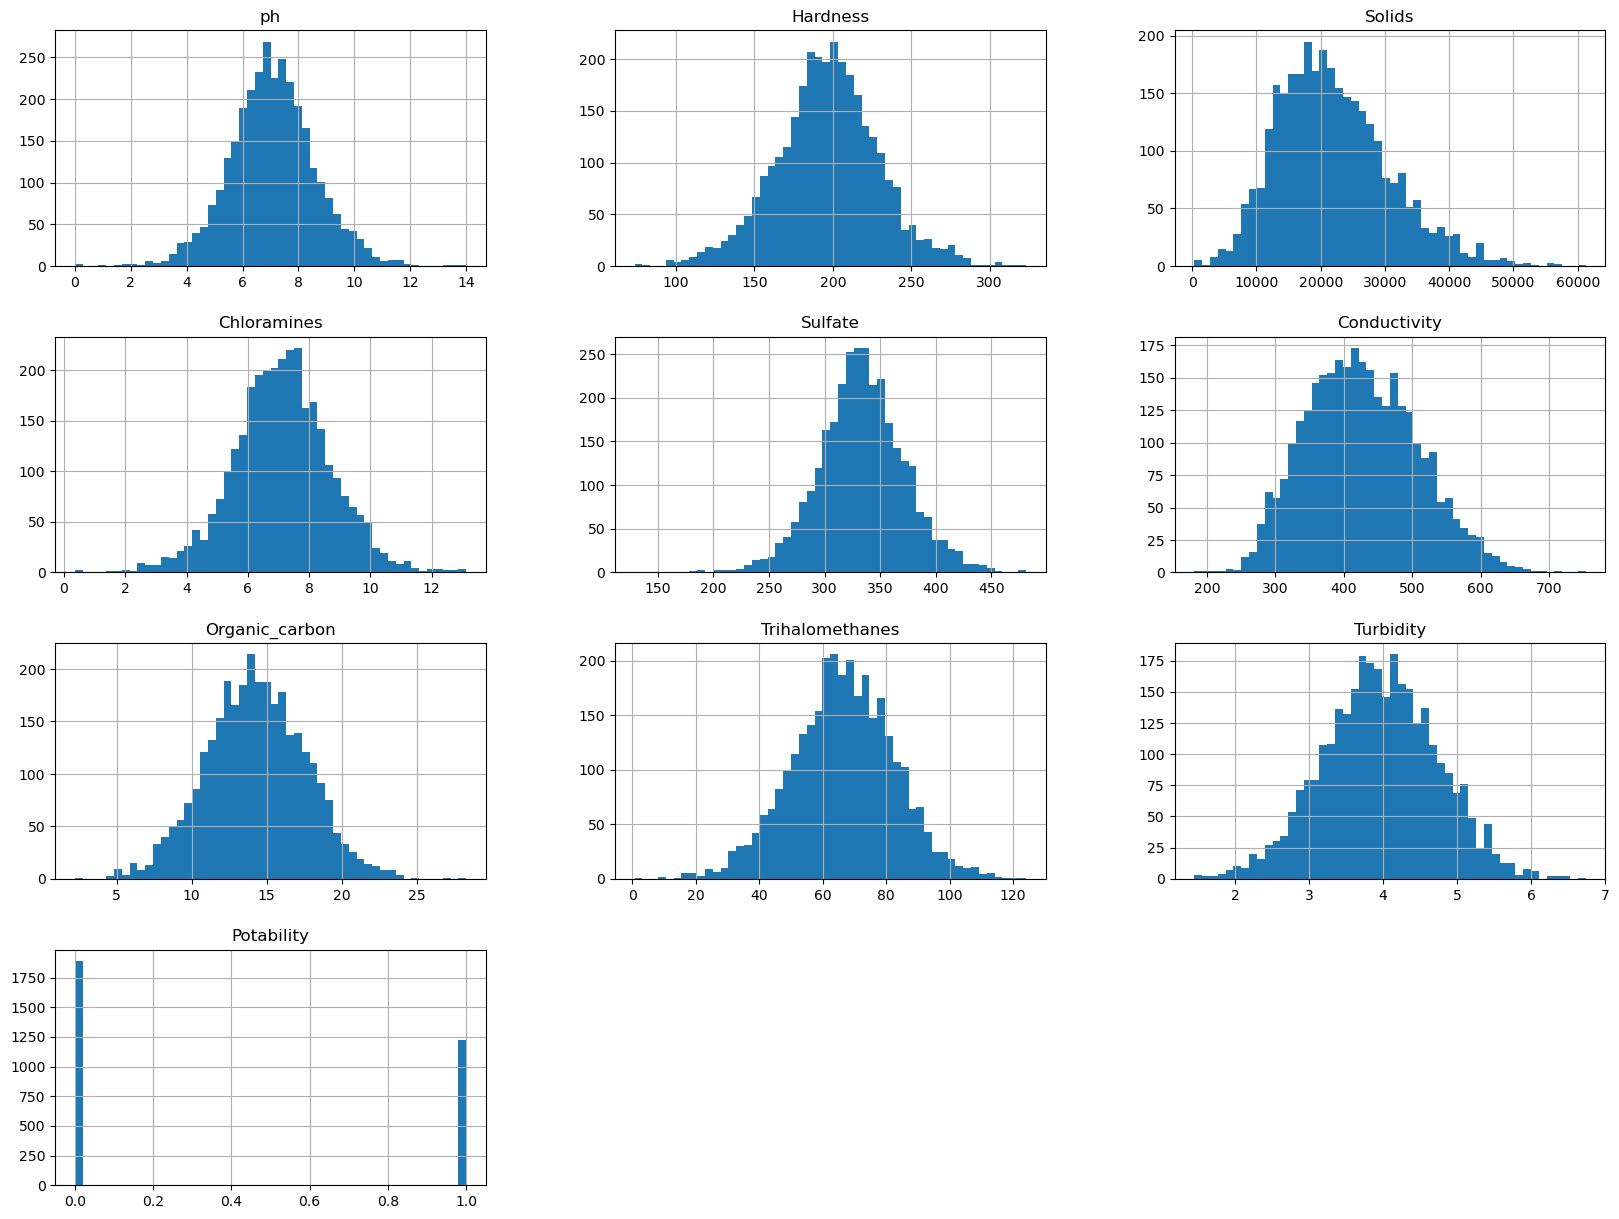

In [62]:
data.hist(bins=50, figsize=(20,15))
plt.show()

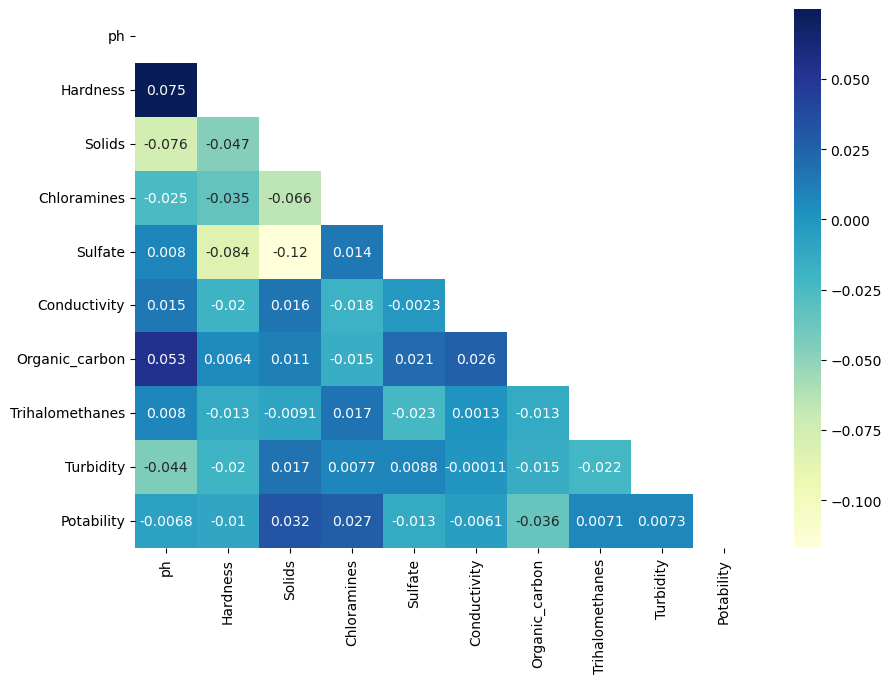

In [63]:
plt.figure(figsize=(10,7))
# creating mask
mask = np.triu(np.ones_like(data.corr()))
heatmap = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, mask=mask) 

The correlation coefficients for almost all combinations are quite low indicating that it is unlikely that we have collinearity present in the dataset.

Most of the columns follow a normal distribution.

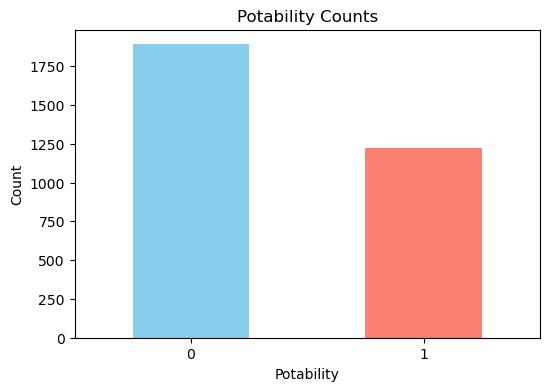

In [64]:
plt.figure(figsize=(6, 4))
data['Potability'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Potability Counts')
plt.xlabel('Potability')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [65]:
data.Potability.value_counts()

0    1891
1    1223
Name: Potability, dtype: int64

The dataset is imbalanced since there are many more false responses than true ones.

In [66]:
zero  = data[data['Potability']==0]   #zero values in Potability column
one = data[data['Potability']==1]  # one values in Potability column
from sklearn.utils import resample
df_minority_upsampled = resample(one, replace = True, n_samples = 1891) 
#concatenate
data = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle
data = shuffle(data) # shuffling so that there is particular sequence

In [67]:
data.Potability.value_counts()

1    1891
0    1891
Name: Potability, dtype: int64

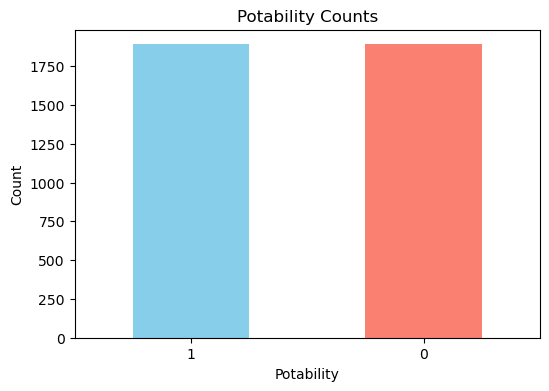

In [68]:
plt.figure(figsize=(6, 4))
data['Potability'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Potability Counts')
plt.xlabel('Potability')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
#the dataset is balanced now

In [69]:
data.corr().abs()['Potability'].sort_values(ascending = False)

Potability         1.000000
Chloramines        0.044790
Organic_carbon     0.039531
Solids             0.037986
Hardness           0.026612
Turbidity          0.024169
Conductivity       0.021652
Sulfate            0.015039
Trihalomethanes    0.010358
ph                 0.006346
Name: Potability, dtype: float64

### Machine Learning with the models: Random Forest, Decision Trees, XGBoost

#### Feature Engineering and Normalization

In [70]:
target_column = 'Potability'
X = data.drop(columns=[target_column])
y = data[target_column]

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Step 2: Feature Engineering 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Model Fitting and Hyperparameter Tuning

In [71]:
# Step 3: Model Training and Hyperparameter Tuning for Decision Trees
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 42],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_model = DecisionTreeClassifier(random_state=random_state)
dt_grid = GridSearchCV(dt_model, dt_params, cv=5)
dt_grid.fit(X_train_scaled, y_train)
best_dt_model = dt_grid.best_estimator_
print("The best hyperparameters for Decision Trees:\n", dt_grid.best_params_)

The best hyperparameters for Decision Trees:
 {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [72]:
# Step 4: Model Training and Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [2, 7, 30],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=random_state)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5)
rf_grid.fit(X_train_scaled, y_train)
best_rf_model = rf_grid.best_estimator_
print("The best hyperparameters for Random Forest:\n", rf_grid.best_params_)

The best hyperparameters for Random Forest:
 {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}


In [73]:
# Step 5: Model Training and Hyperparameter Tuning for XGBoost
xgb_params = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [0.01, 0.5, 0.8],
    'max_depth': [3, 5, 7]
}

xgb_model = XGBClassifier(random_state=random_state)
xgb_grid = RandomizedSearchCV(xgb_model, xgb_params, cv=5)
xgb_grid.fit(X_train, y_train)
best_xgb_model = xgb_grid.best_estimator_
print("The best hyperparameters for XGBoost:\n", xgb_grid.best_params_)

The best hyperparameters for XGBoost:
 {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.5}


#### Model Evaluation using evaluation metrics

In [74]:
# Step 6: Model Evaluation
def evaluate_model_with_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    # Specificity
    tn, fp, fn, tp = confusion_mat.ravel()
    specificity = tn / (tn + fp)
    
    # F1 Score
    f1_score = 2 * (tp / (2 * tp + fp + fn))
    
    # ROC Curve
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Cross-validated Misclassification Rate
    cv_misclassification_rate = 1 - cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
    
    return {
        'Accuracy': accuracy.round(4),
        'Confusion Matrix': confusion_mat,
        'Specificity': specificity,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc,
        'Cross-validated Misclassification Rate': cv_misclassification_rate,
        'Classification Report': classification_rep
    }


In [75]:
# Evaluate Decision Tree
dt_metrics = evaluate_model_with_metrics(best_dt_model, X_test_scaled, y_test)
print("Decision Tree Metrics:")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value}")

Decision Tree Metrics:
Accuracy: 0.7834
Confusion Matrix: [[244 113]
 [ 51 349]]
Specificity: 0.6834733893557423
F1 Score: 0.8097447795823666
ROC AUC: 0.7779866946778712
Cross-validated Misclassification Rate: 0.24140543638562129
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.68      0.75       357
           1       0.76      0.87      0.81       400

    accuracy                           0.78       757
   macro avg       0.79      0.78      0.78       757
weighted avg       0.79      0.78      0.78       757



In [76]:
# Evaluate Random Forest
rf_metrics = evaluate_model_with_metrics(best_rf_model, X_test_scaled, y_test)
print("\nRandom Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")



Random Forest Metrics:
Accuracy: 0.8573
Confusion Matrix: [[303  54]
 [ 54 346]]
Specificity: 0.8487394957983193
F1 Score: 0.865
ROC AUC: 0.9249299719887956
Cross-validated Misclassification Rate: 0.15388962277997942
Classification Report:               precision    recall  f1-score   support

           0       0.85      0.85      0.85       357
           1       0.86      0.86      0.86       400

    accuracy                           0.86       757
   macro avg       0.86      0.86      0.86       757
weighted avg       0.86      0.86      0.86       757



In [77]:
# Evaluate XGBoost
xgb_metrics = evaluate_model_with_metrics(best_xgb_model, X_test_scaled, y_test)
print("\nXGBoost Metrics:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value}")


XGBoost Metrics:
Accuracy: 0.5297
Confusion Matrix: [[  1 356]
 [  0 400]]
Specificity: 0.0028011204481792717
F1 Score: 0.6920415224913494
ROC AUC: 0.4926750700280112
Cross-validated Misclassification Rate: 0.19037309625156384
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.01       357
           1       0.53      1.00      0.69       400

    accuracy                           0.53       757
   macro avg       0.76      0.50      0.35       757
weighted avg       0.75      0.53      0.37       757



#### Model Selection

In [78]:
# Model Selection based on Accuracy
best_model = max([(dt_metrics['Accuracy'], 'Decision Tree'), (rf_metrics['Accuracy'], 'Random Forest'), (xgb_metrics['Accuracy'], 'XGBoost')])

print(f"\nBest Model: {best_model[1]} with accuracy {best_model[0]:.4f}")


Best Model: Random Forest with accuracy 0.8573


#### Plotting the Confusion Matrix and the ROC Curve for the best model: Random Forest

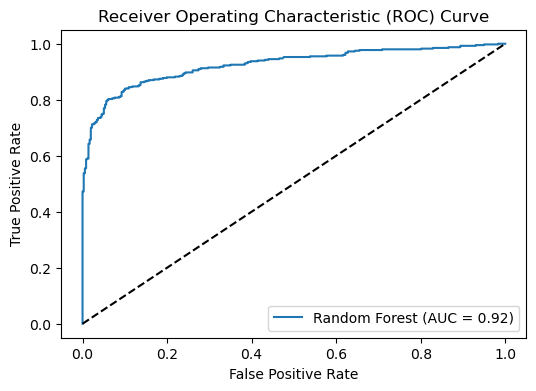

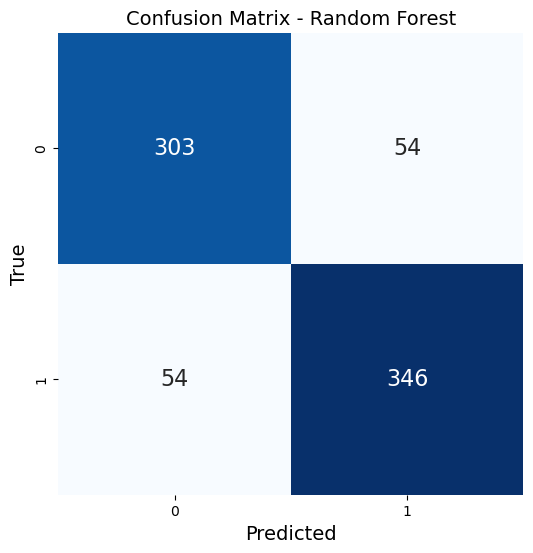

In [83]:
fpr, tpr, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'{best_model[1]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))

conf_matrix = rf_metrics['Confusion Matrix']
annot_kws = {"size": 16}
if conf_matrix.shape == (2, 2):  # binary classification problem
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws=annot_kws)
    plt.title('Confusion Matrix - Random Forest', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()
else:
    print(f"Invalid or empty confusion matrix for Decision Tree. Unable to plot.")


Feature Importance

In [81]:
feature_importances=best_rf_model.feature_importances_
feature_importances_df=pd.DataFrame({'features':list(X_train), 'feature_importances':feature_importances})
feature_importances_df.sort_values('feature_importances',ascending=False)

,features,feature_importances
4,Sulfate,0.153912
0,ph,0.135407
1,Hardness,0.118066
3,Chloramines,0.113326
2,Solids,0.106933
7,Trihalomethanes,0.095521
5,Conductivity,0.093278
6,Organic_carbon,0.092882
8,Turbidity,0.090676
